In [1]:
!pip install tensorflow-hub
!pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.9.2
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [3]:
train_data, validation_data, test_data = tfds.load(
    name="emnist/letters", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/88800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/3.0.0.incompleteWQJ5KU/emnist-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/14800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/3.0.0.incompleteWQJ5KU/emnist-test.tfrecord*...:   0%|     …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/letters/3.0.0. Subsequent calls will reuse this data.


In [4]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

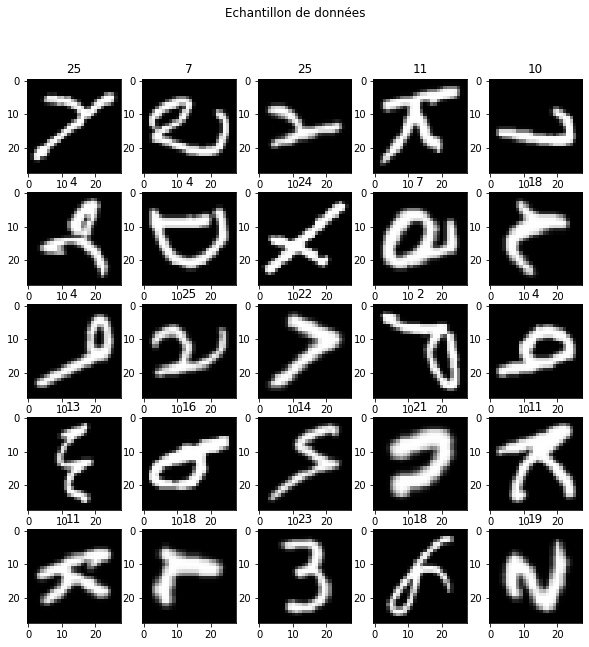

In [5]:
ds = train_data.take(25)
fig = matplotlib.pyplot.figure(figsize=(10,10))
fig.suptitle("Echantillon de données")
id = 22
i = 1
for image, label in tfds.as_numpy(ds):
  ax = fig.add_subplot(5, 5, i)
  i += 1
  ax.imshow(image[:, :, 0], cmap="gray")
  ax.set_title(label)
  ax.grid(False)

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(62, activation='relu'),
    tf.keras.layers.Dense(37)
])

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20
105/105 [==============================] - 10s 79ms/step - loss: 8.7427 - accuracy: 0.0985 - val_loss: 3.1795 - val_accuracy: 0.1660
Epoch 2/20
105/105 [==============================] - 3s 25ms/step - loss: 2.7357 - accuracy: 0.2852 - val_loss: 2.2883 - val_accuracy: 0.4159
Epoch 3/20
105/105 [==============================] - 3s 25ms/step - loss: 1.8801 - accuracy: 0.4992 - val_loss: 1.6819 - val_accuracy: 0.5517
Epoch 4/20
105/105 [==============================] - 3s 25ms/step - loss: 1.4479 - accuracy: 0.5904 - val_loss: 1.3849 - val_accuracy: 0.6154
Epoch 5/20
105/105 [==============================] - 3s 25ms/step - loss: 1.1706 - accuracy: 0.6576 - val_loss: 1.1520 - val_accuracy: 0.6703
Epoch 6/20
105/105 [==============================] - 3s 25ms/step - loss: 0.9685 - accuracy: 0.7115 - val_loss: 1.0635 - val_accuracy: 0.7015
Epoch 7/20
105/105 [==============================] - 3s 25ms/step - loss: 0.8301 - accuracy: 0.7494 - val_loss: 0.9287 - val_accuracy: 0.740

In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

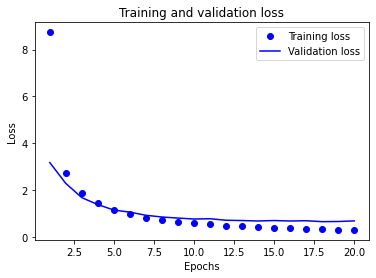

In [10]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

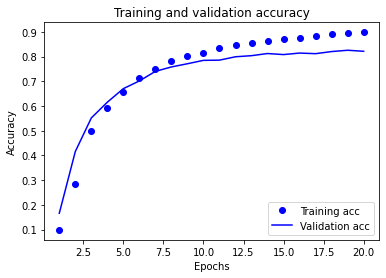

In [11]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [12]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

29/29 - 1s - loss: 0.7550 - accuracy: 0.8013 - 1s/epoch - 49ms/step
loss: 0.755
accuracy: 0.801


In [13]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [20]:
test, test_labels = next(iter(train_data.batch(10)))
test_labels = test_labels.numpy()

In [21]:
predictions = probability_model.predict(test, verbose=2)
predictions.shape

1/1 - 0s - 79ms/epoch - 79ms/step


(10, 37)

In [28]:
labels = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l",
"m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

prediction :  y ; true label :  y
prediction :  q ; true label :  g
prediction :  y ; true label :  y
prediction :  k ; true label :  k
prediction :  j ; true label :  j
prediction :  d ; true label :  d
prediction :  d ; true label :  d
prediction :  x ; true label :  x
prediction :  g ; true label :  g
prediction :  r ; true label :  r


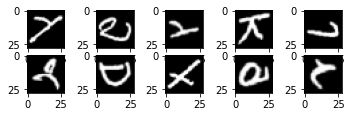

In [34]:
fig = matplotlib.pyplot.figure()
for i in range(10):
    label = np.argmax(predictions[i])
    print("prediction : ", labels[label - 1], "; true label : ", labels[test_labels[i] - 1])
    ax = fig.add_subplot(5, 5, i + 1)
    ax.imshow(test[i][:,:,0], cmap="gray")